# 1. Setup

### 1.1 Install Dependencies

In [ ]:
!pip install tensorflow==2.4.1  opencv-python matplotlib

### 1.2 Import dependencies

In [52]:
import tensorflow as tf
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import mtcnn
from PIL import Image
import glob

In [53]:
# Import Tensorflow dependencies
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.layers import BatchNormalization, ZeroPadding2D

# 2. DataSet and preprocessing

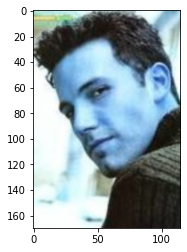

(170, 115, 3)


In [54]:
# Image example
img = cv2.imread('data/train/ben_afflek/httpcsvkmeuaeccjpg.jpg')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(img.shape)

In [55]:
# Extract a single face from a given photograph
# using mtcnn lib
def extract_face(filename, required_size=(96, 96)):
    
    # Load image from file
    image = Image.open(filename)
    
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    
    # create the detector, using default weights
    detector = mtcnn.MTCNN()
    
    # detect faces in the image
    results = detector.detect_faces(pixels)
    
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    # extract the face
    face = pixels[y1:y2, x1:x2]
    
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)

    face_array = np.asarray(image)

    return face_array

original image: (185, 150, 3)


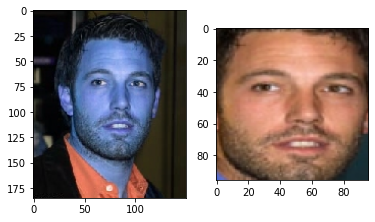

face extracted: (96, 96, 3)


In [56]:
# Test extract_image()
filename = 'data/train/ben_afflek/httpwwwfilmscoopitcgibinattoriBENAFFLECKBENAFFLECKjpg.jpg'
img = cv2.imread(filename)
plt.subplot(1,2,1)
plt.imshow(img)
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
print('original image:',img.shape)
face = extract_face(filename, required_size=(96, 96))
plt.subplot(1,2,2)
plt.imshow(face)
plt.show()
print('face extracted:',face.shape)

In [57]:
# Apply extract_face() to all images
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in glob.glob(os.path.join(dir,'*.jpg')):
        #path = dir + filename
        path = filename
        face = extract_face(path,required_size=(160, 160))
        faces.append(face)
            
    return faces

In [58]:
# Load data set
def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        if os.path.isdir(path):
            faces = load_face(path)
            labels = [subdir for i in range(len(faces))]
            print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
            X.extend(faces)
            y.extend(labels)
    return np.asarray(X), np.asarray(y)

In [59]:
# load train dataset, detect faces and preprocess
X_train, y_train = load_dataset('data/train/')
print(X_train.shape, y_train.shape)


loaded 14 sample for class: ben_afflek
loaded 2 sample for class: wala
loaded 18 sample for class: madonna
loaded 17 sample for class: elton_john
loaded 1 sample for class: yacine
(52, 160, 160, 3) (52,)


In [60]:

# load, detect faces and preprocess val dataset
X_val, y_val = load_dataset('data/val/')
print(X_val.shape, y_val.shape)

loaded 5 sample for class: ben_afflek
loaded 5 sample for class: madonna
loaded 5 sample for class: elton_john
(15, 160, 160, 3) (15,)


# 3. Face Recognition

### 3.1 Loading the trained model

FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, we won't train it from scratch here. Instead, we load a previously trained model. Load a model using the following cell; this might take a couple of minutes to run. 

In [61]:
facenet_model = load_model('input/facenet_keras.h5')
print('Model Loaded')

Model Loaded


In [62]:
facenet_model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                                

In [63]:
# Compute embedding vector using pretrained model
def get_embedding(face, model):
    
    # scale pixel values
    face = face.astype('float32')
    
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]

In [64]:
# convert each face in the train set into embedding
X_train_emb = list()
for face in X_train:
    emd = get_embedding(face,facenet_model)
    X_train_emb.append(emd)
    
X_train_emb = np.asarray(X_train_emb)
print(X_train_emb.shape)

# convert each face in the test set into embedding
X_val_emb = list()
for face in X_val:
    emd = get_embedding(face,facenet_model)
    X_val_emb.append(emd)
X_val_emb = np.asarray(X_val_emb)
print(X_val_emb.shape)


(52, 128)
(15, 128)


In [65]:
# Transform a given image into embedding vector
def img_to_emb(image_path,model):
    
    face = extract_face(image_path,required_size=(160, 160))
    plt.imshow(face)
    plt.show()
    face_embedding = get_embedding(face, model)

    return face_embedding
    

In [66]:
# Compute distance between a given embedding vector to the embedding vectors of the dataset
def compute_dist(embedding,dataset_emb):
    
    distances = np.linalg.norm((embedding.T - dataset_emb),axis=1)
    distances = (distances - np.min(distances))/(np.max(distances)-np.min(distances))
    
    return(distances)
    


In [67]:
# Given an image, transform to an embedding vector and compute the distances
def verify(image_path,database,labels,model,identif_thresh = 0.05):
    # Fucntion to verify if person 'image_path' is identity
    
    # Arguments:
    #   image -- path to an image
    #   identity -- name of person you'd like to verify
    #   database -- python dict mapping names of allowed people's names to their embedding vectors
    #   model -- FacetNet model

    # Returns:
    #   dist -- distance between image_path and image od identity
    #   flag -- True if person is the database. False otherwise

    # ---------------------------------------------------------------------

    # Step 1: Compute the embedding vector for the image.
    embedding = img_to_emb(image_path, model)

    # Step2: Compute disntances with database
    distances = compute_dist(embedding,database)
    dist_min = np.min(distances)
    label_ind = np.argmin(distances)

    # Step 3: identify ok if dist < identif_thresh.7
    if dist_min < identif_thresh:
        identity = labels[label_ind]
        print(identif_thresh)
        print("It's " + str(identity) + ", welcome!")
        print("Score:",100*(1-dist_min))
        
    else:
        print("Sorry, you are not in the database !")
        identity = 'None'

    return dist_min, identity
    

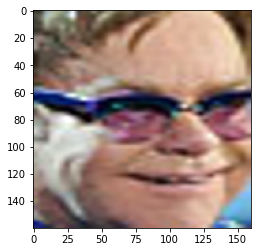

0.05
It's elton_john, welcome!
Score: 100.0


In [68]:
dist,flag = verify("data/val/elton_john/httpcdncdnjustjaredcomwpcontentuploadsheadlineseltonjohnemmysperformancewatchnowjpg.jpg",
X_train_emb, y_train,facenet_model)

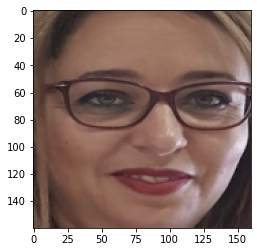

0.05
It's wala, welcome!
Score: 100.0


In [69]:

dist,flag = verify("/Users/wala/Desktop/wala.png", X_train_emb, y_train,facenet_model)

# 4. Evaluation

In [247]:
!pip install sklearn

  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Preparing metadata (setup.py) ... done
  Using cached scikit_learn-1.0.2-cp37-cp37m-macosx_10_13_x86_64.whl (7.8 MB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached scipy-1.7.3-cp37-cp37m-macosx_10_9_x86_64.whl (33.0 MB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=68c6df0a22834264aba166f7dfecdcebe8711556da88835a80eb101253379e33
  Stored in directory: /Users/wala/Library/Caches/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [22]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import recall_score, precision_score
from sklearn.preprocessing import LabelEncoder

In [51]:
# Encoder categorical label
le = LabelEncoder()
le.fit(y_train)
y_train_num = le.transform(y_train)
y_val_num = le.transform(y_val)

In [46]:
# Evaluation of validation set
def eval_validation(embedding_val,label_val,dataset_emb,labels,identif_thresh = .05):
    # Creating a metric object 
    r = Recall()
    p = Precision()
    R = []
    P = []
    yhat = []
    for embedding,y_true in zip(X_val_emb,label_val):
        # Step1: Compute disntances with database
        distances = compute_dist(embedding,dataset_emb)
        dist_min = np.min(distances)
        label_ind = np.argmin(distances)

        # Step 2: identify ok if dist < identif_thresh.7
        if dist_min < identif_thresh:
            yhat.append((labels[label_ind]))
        else:
            yhat.append(('None'))
        
       
    R = recall_score(label_val, yhat,average=None)
    P = precision_score(label_val, yhat,average=None)

    return R,P,yhat
        

In [47]:
R,P,yhat = eval_validation(X_val_emb,y_val_num,X_train_emb,y_train_num,identif_thresh = .05)


# 4. Real Time Verification

In [234]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    #frame = frame[175:175+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('data', 'input_image.jpg'), frame)
        # Run verification
        dist,identity = verify(os.path.join('data', 'input_image.jpg'), X_train_emb, y_train,facenet_model)

        
        #print(identity,dist)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()